# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
# import data

warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-06-30'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed

1 Failed download:
['SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2016-07-02 00:00:00 -> 2024-06-30) (Yahoo error = "Data doesn\'t exist for startDate = 1467432000, endDate = 1719720000")')


Price                              adj close       close        high  \
date                      ticker                                       
2016-07-05 00:00:00+00:00 A        41.086143   43.750000   44.349998   
                          AAL      27.802402   28.930000   29.160000   
                          AAPL     21.786543   23.747499   23.850000   
                          ABBV     43.482292   61.919998   62.709999   
                          ABT      33.861187   39.439999   39.560001   
...                                      ...         ...         ...   
2024-06-28 00:00:00+00:00 XYL     135.270508  135.630005  137.990005   
                          YUM     131.802368  132.460007  132.990005   
                          ZBH     108.529999  108.529999  109.580002   
                          ZBRA    308.929993  308.929993  314.040009   
                          ZTS     172.948624  173.360001  177.070007   

Price                                    low        open       volume  
date                      ticker                                       
2016-07-05 00:00:00+00:00 A        43.630001   44.310001    1813500.0  
                          AAL      28.190001   29.090000    9467000.0  
                          AAPL     23.615000   23.847500  110820800.0  
                          ABBV     61.770000   62.500000    6293600.0  
                          ABT      39.209999   39.310001   10029300.0  
...                                      ...         ...          ...  
2024-06-28 00:00:00+00:00 XYL     134.300003  136.639999    2197600.0  
                          YUM     131.720001  132.509995    5819000.0  
                          ZBH     107.379997  108.550003    2774600.0  
                          ZBRA    306.160004  309.000000     417900.0  
                          ZTS     173.029999  176.460007    4189600.0  

[989314 rows x 6 columns]

In [3]:
df1 = df
df2 = df.copy()
df3 = df

In [4]:
num, colu = df.loc[pd.IndexSlice['2024-06-06',:],:].shape
num
ticker=df.loc['2024-06-06',:].index
ticker

Index(['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI',
       ...
       'WTW', 'WY', 'WYNN', 'XEL', 'XOM', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZTS'],
      dtype='object', name='ticker', length=502)

In [5]:
df_pred=df

In [6]:
features = ['Year', 'Month', 'Week', 'Day of the month', 'log_return', 'sma_50', 'sma_200', 'rsi']
targets = ['close', 'adj close', 'volume', 'high', 'low', 'open']

i = 0
for i in range(0,num):

    df_aapl = df1.loc[pd.IndexSlice[:, ticker[i]], :]
    df_aapl=df_aapl.reset_index()
    df_aapl['log_return'] = np.log(df_aapl['close'] / df_aapl['close'].shift(1))
    df_aapl['sma_50'] = df_aapl['close'].rolling(window=50).mean()
    df_aapl['sma_200'] = df_aapl['close'].rolling(window=200).mean()
    df_aapl['rsi'] = 100 - (100 / (1 + (df_aapl['close'].diff().rolling(window=14).mean() / df_aapl['close'].diff().rolling(window=14).std())))

    last_date = df_aapl['date'].max()
    new_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=150)
    new_data = {
    'date': new_dates,
    'ticker': ticker[i],
    'adj close': 0,
    'close': 0,
    'high': 0,
    'low': 0,
    'open': 0,
    'volume': 0,
    'log_return':0,
    'sma_200':0,
    'sma_50':0,
    'rsi':0
    }
    new_df = pd.DataFrame(new_data)
    df_aapl = pd.concat([df_aapl, new_df], ignore_index=True)

    df_aapl['Month'] = df_aapl['date'].dt.month
    df_aapl['Year'] = df_aapl['date'].dt.year
    df_aapl['Week'] = df_aapl['date'].dt.isocalendar().week
    df_aapl['Day of the month'] = df_aapl['date'].dt.day
    
    df_aapl.set_index('date', inplace=True)
    X = df_aapl[features]
    y = df_aapl[targets]
    
    train_size = len(df_aapl) - 150
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Train the XGBoost model for each target
    models = {}
    for target in targets:
        model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
        model.fit(X_train, y_train[target])
        models[target] = model

    # Make predictions for each target
    predictions = {}
    for target in targets:
        predictions[target] = models[target].predict(X_test)

    # Combine predictions into a DataFrame
    predicted_df = pd.DataFrame(predictions, index=X_test.index)
    predicted_df['ticker']=ticker[i]
#     predicted_df = predicted_df.reset_index()
#     predicted_df.set_index('ticker', append=True, inplace=True)
    predicted_df.set_index(['ticker', predicted_df.index], inplace=True)
    predicted_df.index.names = ['ticker', 'date']
    predicted_df = predicted_df.reorder_levels(['date', 'ticker'])
  
    df = pd.concat([df2, predicted_df], ignore_index=False)


In [7]:
df_final = df
df_final1 = df

In [8]:
df = df.sort_index()
df

adj close      close       high        low  \
date                      ticker                                               
2016-07-05 00:00:00+00:00 A       41.086143  43.750000  44.349998  43.630001   
                          AAL     27.802402  28.930000  29.160000  28.190001   
                          AAPL    21.786543  23.747499  23.850000  23.615000   
                          ABBV    43.482292  61.919998  62.709999  61.770000   
                          ABT     33.861187  39.439999  39.560001  39.209999   
...                                     ...        ...        ...        ...   
2024-11-21 00:00:00+00:00 ZTS     51.094151  53.862957  55.701801  54.420925   
2024-11-22 00:00:00+00:00 ZTS     51.117985  53.978157  55.873470  54.420925   
2024-11-23 00:00:00+00:00 ZTS     51.117985  54.042473  55.873470  54.420925   
2024-11-24 00:00:00+00:00 ZTS     51.117985  54.090767  55.873287  54.527939   
2024-11-25 00:00:00+00:00 ZTS     51.117985  54.090767  55.873287  55.323456   

                                       open        volume  
date                      ticker                           
2016-07-05 00:00:00+00:00 A       44.310001  1.813500e+06  
                          AAL     29.090000  9.467000e+06  
                          AAPL    23.847500  1.108208e+08  
                          ABBV    62.500000  6.293600e+06  
                          ABT     39.310001  1.002930e+07  
...                                     ...           ...  
2024-11-21 00:00:00+00:00 ZTS     54.946949  2.592042e+06  
2024-11-22 00:00:00+00:00 ZTS     55.059685  2.390459e+06  
2024-11-23 00:00:00+00:00 ZTS     55.059685  2.109866e+06  
2024-11-24 00:00:00+00:00 ZTS     55.123386  2.109866e+06  
2024-11-25 00:00:00+00:00 ZTS     55.259567  2.261112e+06  

[989464 rows x 6 columns]

In [9]:
# df_final = df_final.sortlevel()
df_final = df_final.groupby(level=[0,1]).sum()
df_final

adj close      close       high        low  \
date                      ticker                                               
2016-07-05 00:00:00+00:00 A       41.086143  43.750000  44.349998  43.630001   
                          AAL     27.802402  28.930000  29.160000  28.190001   
                          AAPL    21.786543  23.747499  23.850000  23.615000   
                          ABBV    43.482292  61.919998  62.709999  61.770000   
                          ABT     33.861187  39.439999  39.560001  39.209999   
...                                     ...        ...        ...        ...   
2024-11-21 00:00:00+00:00 ZTS     51.094151  53.862957  55.701801  54.420925   
2024-11-22 00:00:00+00:00 ZTS     51.117985  53.978157  55.873470  54.420925   
2024-11-23 00:00:00+00:00 ZTS     51.117985  54.042473  55.873470  54.420925   
2024-11-24 00:00:00+00:00 ZTS     51.117985  54.090767  55.873287  54.527939   
2024-11-25 00:00:00+00:00 ZTS     51.117985  54.090767  55.873287  55.323456   

                                       open        volume  
date                      ticker                           
2016-07-05 00:00:00+00:00 A       44.310001  1.813500e+06  
                          AAL     29.090000  9.467000e+06  
                          AAPL    23.847500  1.108208e+08  
                          ABBV    62.500000  6.293600e+06  
                          ABT     39.310001  1.002930e+07  
...                                     ...           ...  
2024-11-21 00:00:00+00:00 ZTS     54.946949  2.592042e+06  
2024-11-22 00:00:00+00:00 ZTS     55.059685  2.390459e+06  
2024-11-23 00:00:00+00:00 ZTS     55.059685  2.109866e+06  
2024-11-24 00:00:00+00:00 ZTS     55.123386  2.109866e+06  
2024-11-25 00:00:00+00:00 ZTS     55.259567  2.261112e+06  

[989464 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [10]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

adj close      close       high        low  \
date                      ticker                                               
2016-07-05 00:00:00+00:00 A       41.086143  43.750000  44.349998  43.630001   
                          AAL     27.802402  28.930000  29.160000  28.190001   
                          AAPL    21.786543  23.747499  23.850000  23.615000   
                          ABBV    43.482292  61.919998  62.709999  61.770000   
                          ABT     33.861187  39.439999  39.560001  39.209999   
...                                     ...        ...        ...        ...   
2024-11-21 00:00:00+00:00 ZTS     51.094151  53.862957  55.701801  54.420925   
2024-11-22 00:00:00+00:00 ZTS     51.117985  53.978157  55.873470  54.420925   
2024-11-23 00:00:00+00:00 ZTS     51.117985  54.042473  55.873470  54.420925   
2024-11-24 00:00:00+00:00 ZTS     51.117985  54.090767  55.873287  54.527939   
2024-11-25 00:00:00+00:00 ZTS     51.117985  54.090767  55.873287  55.323456   

                                       open        volume  garman_klass_vol  \
date                      ticker                                              
2016-07-05 00:00:00+00:00 A       44.310001  1.813500e+06         -0.002070   
                          AAL     29.090000  9.467000e+06         -0.000219   
                          AAPL    23.847500  1.108208e+08         -0.003107   
                          ABBV    62.500000  6.293600e+06         -0.050735   
                          ABT     39.310001  1.002930e+07         -0.008561   
...                                     ...           ...               ...   
2024-11-21 00:00:00+00:00 ZTS     54.946949  2.592042e+06         -0.001771   
2024-11-22 00:00:00+00:00 ZTS     55.059685  2.390459e+06         -0.001785   
2024-11-23 00:00:00+00:00 ZTS     55.059685  2.109866e+06         -0.001785   
2024-11-24 00:00:00+00:00 ZTS     55.123386  2.109866e+06         -0.001901   
2024-11-25 00:00:00+00:00 ZTS     55.259567  2.261112e+06         -0.002296   

                                        rsi    bb_low    bb_mid   bb_high  \
date                      ticker                                            
2016-07-05 00:00:00+00:00 A             NaN       NaN       NaN       NaN   
                          AAL           NaN       NaN       NaN       NaN   
                          AAPL          NaN       NaN       NaN       NaN   
                          ABBV          NaN       NaN       NaN       NaN   
                          ABT           NaN       NaN       NaN       NaN   
...                                     ...       ...       ...       ...   
2024-11-21 00:00:00+00:00 ZTS     44.624127  3.948360  3.952378  3.956396   
2024-11-22 00:00:00+00:00 ZTS     45.750208  3.948956  3.952620  3.956283   
2024-11-23 00:00:00+00:00 ZTS     45.750208  3.949663  3.952862  3.956060   
2024-11-24 00:00:00+00:00 ZTS     45.750208  3.949714  3.952917  3.956120   
2024-11-25 00:00:00+00:00 ZTS     45.750208  3.949769  3.952972  3.956176   

                                       atr      macd  dollar_volume  
date                      ticker                                     
2016-07-05 00:00:00+00:00 A            NaN       NaN      74.509721  
                          AAL          NaN       NaN     263.205344  
                          AAPL         NaN       NaN    2414.402113  
                          ABBV         NaN       NaN     273.660154  
                          ABT          NaN       NaN     339.604003  
...                                    ...       ...            ...  
2024-11-21 00:00:00+00:00 ZTS    -0.936999 -0.011773     132.438171  
2024-11-22 00:00:00+00:00 ZTS    -0.905217 -0.010605     122.195434  
2024-11-23 00:00:00+00:00 ZTS    -0.880793 -0.009617     107.852124  
2024-11-24 00:00:00+00:00 ZTS    -0.860964 -0.008780     107.852124  
2024-11-25 00:00:00+00:00 ZTS    -0.844685 -0.008073     115.583489  

[989464 rows x 14 columns]

In [11]:
df_feature = df

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [12]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume  adj close  garman_klass_vol  \
date                      ticker                                               
2016-08-31 00:00:00+00:00 A           87.662068  44.119465         -0.001640   
                          AAL        269.710264  34.989552         -0.000479   
                          AAPL      2715.831943  24.466515         -0.002230   
                          ABBV       306.400098  45.408329         -0.046259   
                          ABT        375.329242  36.298470         -0.010390   
...                                         ...        ...               ...   
2024-07-31 00:00:00+00:00 ZTS        171.381090  51.490368         -0.001331   
2024-08-31 00:00:00+00:00 ZTS        176.110941  51.488026         -0.001333   
2024-09-30 00:00:00+00:00 ZTS        176.634880  51.557621         -0.001249   
2024-10-31 00:00:00+00:00 ZTS        173.786591  51.284229         -0.001248   
2024-11-30 00:00:00+00:00 ZTS        176.787117  51.117985         -0.002296   

                                        rsi    bb_low    bb_mid   bb_high  \
date                      ticker                                            
2016-08-31 00:00:00+00:00 A       50.780857  3.799092  3.820731  3.842369   
                          AAL     59.063147  3.511263  3.567882  3.624500   
                          AAPL    57.326705  3.234194  3.254363  3.274532   
                          ABBV    42.552832  3.835019  3.867038  3.899057   
                          ABT     38.739513  3.624830  3.667518  3.710207   
...                                     ...       ...       ...       ...   
2024-07-31 00:00:00+00:00 ZTS     13.866981  3.957187  3.959279  3.961371   
2024-08-31 00:00:00+00:00 ZTS     17.529033  3.955629  3.958497  3.961364   
2024-09-30 00:00:00+00:00 ZTS     28.897588  3.957286  3.960159  3.963032   
2024-10-31 00:00:00+00:00 ZTS     39.265241  3.953468  3.956927  3.960386   
2024-11-30 00:00:00+00:00 ZTS     45.750208  3.949769  3.952972  3.956176   

                                       atr      macd  
date                      ticker                      
2016-08-31 00:00:00+00:00 A      -1.367656 -0.110174  
                          AAL     0.010620  0.859346  
                          AAPL   -1.321606 -0.117384  
                          ABBV   -1.510144 -0.274591  
                          ABT    -1.194762 -0.267446  
...                                    ...       ...  
2024-07-31 00:00:00+00:00 ZTS    -0.669422 -2.378059  
2024-08-31 00:00:00+00:00 ZTS    -1.291711 -0.223795  
2024-09-30 00:00:00+00:00 ZTS    -1.380992 -0.014421  
2024-10-31 00:00:00+00:00 ZTS    -1.446783 -0.013191  
2024-11-30 00:00:00+00:00 ZTS    -0.844685 -0.008073  

[46759 rows x 9 columns]

In [13]:
data_copy = data

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [14]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

data_copy2 = data

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [15]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data
data_final = data

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [19]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

data = data.reset_index()
if data['date'].dt.tz is not None:
    data['date'] = data['date'].dt.tz_localize(None)
data = data.set_index(['date', 'ticker'])

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

TypeError: Cannot join tz-naive with tz-aware DatetimeIndex

* Filter out stocks with less than 10 months of data.

In [23]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-07-31 AAL     0.0319 -0.0193  0.0045  0.0155  0.0035   0.041623
           AAPL    0.0319 -0.0193  0.0045  0.0155  0.0035   0.027983
           ABBV    0.0319 -0.0193  0.0045  0.0155  0.0035   0.005633
           ABT     0.0319 -0.0193  0.0045  0.0155  0.0035   0.079433
           ACN     0.0319 -0.0193  0.0045  0.0155  0.0035  -0.026041
...                   ...     ...     ...     ...     ...        ...
2024-06-30 VRTX    0.0277 -0.0437 -0.0331  0.0051 -0.0178   0.029385
           VZ      0.0277 -0.0437 -0.0331  0.0051 -0.0178   0.002187
           WFC     0.0277 -0.0437 -0.0331  0.0051 -0.0178  -0.008845
           WMT     0.0277 -0.0437 -0.0331  0.0051 -0.0178   0.029653
           XOM     0.0277 -0.0437 -0.0331  0.0051 -0.0178  -0.018250

[10327 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [24]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-07-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-06-30 VRTX    0.486516  0.555350 -0.465483  0.484680  0.499458
           VZ      0.642414 -1.183033  0.521355 -0.036730  0.017167
           WFC     1.025037  0.308624  1.235027 -0.536950 -0.771657
           WMT     0.482211  0.180744 -0.147148  0.923001  0.020111
           XOM     0.742290  0.056886  0.401091  0.849417  0.534676

[10327 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [25]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10168 entries, (Timestamp('2018-07-31 00:00:00'), 'AAL') to (Timestamp('2024-06-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10168 non-null  float64
 1   rsi               10168 non-null  float64
 2   bb_low            10168 non-null  float64
 3   bb_mid            10168 non-null  float64
 4   bb_high           10168 non-null  float64
 5   atr               10168 non-null  float64
 6   macd              10168 non-null  float64
 7   return_1m         10168 non-null  float64
 8   return_2m         10168 non-null  float64
 9   return_3m         10168 non-null  float64
 10  return_6m         10168 non-null  float64
 11  return_9m         10168 non-null  float64
 12  return_12m        10168 non-null  float64
 13  Mkt-RF            10168 non-null  float64
 14  SMB               10168 non-null  float64
 15  HML       

In [26]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-07-31 AAL             0.000092  49.117684  3.591910  3.645691  3.699472   
           AAPL           -0.000930  52.605337  3.807050  3.833190  3.859331   
           ABBV           -0.027194  45.920981  4.225651  4.279128  4.332605   
           ABT            -0.003867  62.882481  4.015925  4.062819  4.109713   
           ACN            -0.003530  42.887767  4.993172  5.023605  5.054037   
...                             ...        ...       ...       ...       ...   
2024-06-30 WMT             0.000056  61.898817  4.194727  4.218951  4.243174   
           XOM             0.000049  53.431099  4.685024  4.724820  4.764615   
           MRNA            0.000545  39.341994  4.796264  4.946746  5.097228   
           UBER            0.000335  58.643118  4.178147  4.252313  4.326479   
           CRWD            0.000343  61.052351  5.742863  5.903966  6.065069   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-07-31 AAL     0.794336 -0.297513   0.041623  -0.047041  -0.026289   
           AAPL   -1.073866 -0.163311   0.027983   0.009109   0.049478   
           ABBV    0.047627 -0.726972   0.005633  -0.029587  -0.011801   
           ABT    -0.940371  0.529881   0.079433   0.034388   0.042361   
           ACN    -0.835028 -0.172550  -0.026041   0.011460   0.017611   
...                     ...       ...        ...        ...        ...   
2024-06-30 WMT     1.258892  1.953788   0.029653   0.069957   0.041337   
           XOM     0.457795 -0.324234  -0.018250  -0.009408  -0.000531   
           MRNA   -0.086434 -0.464483  -0.166959   0.037551   0.036764   
           UBER    0.523438  0.664609   0.125775   0.047247  -0.019020   
           CRWD    1.467939  1.874756   0.221634   0.144496   0.061259   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-07-31 AAL     -0.050880  -0.017899   -0.019393  1.213872  1.506788   
           AAPL     0.022909   0.014540    0.022060  1.317078 -0.316981   
           ABBV    -0.028860   0.005495    0.026310  0.475015  0.499240   
           ABT      0.010427   0.022867    0.025837  0.787656 -0.117529   
           ACN      0.000037   0.013581    0.019435  1.211429 -0.190875   
...                      ...        ...         ...       ...       ...   
2024-06-30 WMT      0.044342   0.028130    0.022803  0.571336 -0.021317   
           XOM      0.026742   0.000589    0.008824  0.794183 -0.088627   
           MRNA     0.030002   0.015618   -0.001906  1.258794  1.581219   
           UBER     0.028034   0.052164    0.044366  1.500693 -0.175124   
           CRWD     0.070011   0.096397    0.083195  0.663850 -1.740222   

                        HML       RMW       CMA  
date       ticker                                
2018-07-31 AAL     0.388119  0.172455  0.802012  
           AAPL   -0.621276  0.424395  0.590279  
           ABBV   -0.196676  0.511657  0.477031  
           ABT    -0.451522  0.239049  0.947823  
           ACN    -0.253962  0.328022  0.078372  
...                     ...       ...       ...  
2024-06-30 WMT    -0.007443  0.770579  0.001230  
           XOM     0.447953  0.752357  0.528448  
           MRNA   -0.365333  2.152725  0.807064  
           UBER   -0.100095 -2.775399 -0.465835  
           CRWD    1.097369 -2.852894 -2.814515  

[10168 rows x 18 columns]

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [27]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [28]:
from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-07-31 AAL             0.000092  49.117684  3.591910  3.645691  3.699472   
           AAPL           -0.000930  52.605337  3.807050  3.833190  3.859331   
           ABBV           -0.027194  45.920981  4.225651  4.279128  4.332605   
           ABT            -0.003867  62.882481  4.015925  4.062819  4.109713   
           ACN            -0.003530  42.887767  4.993172  5.023605  5.054037   
...                             ...        ...       ...       ...       ...   
2024-06-30 WMT             0.000056  61.898817  4.194727  4.218951  4.243174   
           XOM             0.000049  53.431099  4.685024  4.724820  4.764615   
           MRNA            0.000545  39.341994  4.796264  4.946746  5.097228   
           UBER            0.000335  58.643118  4.178147  4.252313  4.326479   
           CRWD            0.000343  61.052351  5.742863  5.903966  6.065069   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-07-31 AAL     0.794336 -0.297513   0.041623  -0.047041  -0.026289   
           AAPL   -1.073866 -0.163311   0.027983   0.009109   0.049478   
           ABBV    0.047627 -0.726972   0.005633  -0.029587  -0.011801   
           ABT    -0.940371  0.529881   0.079433   0.034388   0.042361   
           ACN    -0.835028 -0.172550  -0.026041   0.011460   0.017611   
...                     ...       ...        ...        ...        ...   
2024-06-30 WMT     1.258892  1.953788   0.029653   0.069957   0.041337   
           XOM     0.457795 -0.324234  -0.018250  -0.009408  -0.000531   
           MRNA   -0.086434 -0.464483  -0.166959   0.037551   0.036764   
           UBER    0.523438  0.664609   0.125775   0.047247  -0.019020   
           CRWD    1.467939  1.874756   0.221634   0.144496   0.061259   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-07-31 AAL     -0.050880  -0.017899   -0.019393  1.213872  1.506788   
           AAPL     0.022909   0.014540    0.022060  1.317078 -0.316981   
           ABBV    -0.028860   0.005495    0.026310  0.475015  0.499240   
           ABT      0.010427   0.022867    0.025837  0.787656 -0.117529   
           ACN      0.000037   0.013581    0.019435  1.211429 -0.190875   
...                      ...        ...         ...       ...       ...   
2024-06-30 WMT      0.044342   0.028130    0.022803  0.571336 -0.021317   
           XOM      0.026742   0.000589    0.008824  0.794183 -0.088627   
           MRNA     0.030002   0.015618   -0.001906  1.258794  1.581219   
           UBER     0.028034   0.052164    0.044366  1.500693 -0.175124   
           CRWD     0.070011   0.096397    0.083195  0.663850 -1.740222   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-07-31 AAL     0.388119  0.172455  0.802012        3  
           AAPL   -0.621276  0.424395  0.590279        3  
           ABBV   -0.196676  0.511657  0.477031        0  
           ABT    -0.451522  0.239049  0.947823        1  
           ACN    -0.253962  0.328022  0.078372        0  
...                     ...       ...       ...      ...  
2024-06-30 WMT    -0.007443  0.770579  0.001230        1  
           XOM     0.447953  0.752357  0.528448        3  
           MRNA   -0.365333  2.152725  0.807064        0  
           UBER   -0.100095 -2.775399 -0.465835        1  
           CRWD    1.097369 -2.852894 -2.814515        1  

[10168 rows x 19 columns]

In [29]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


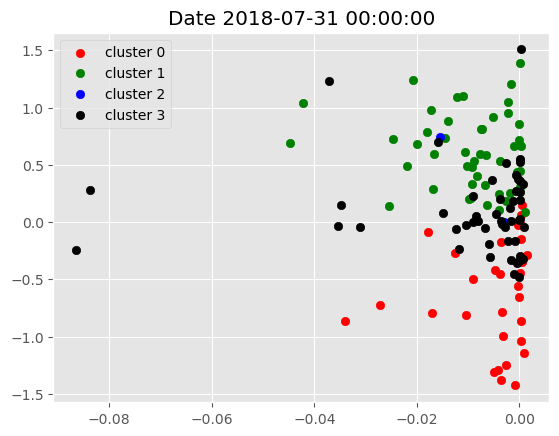

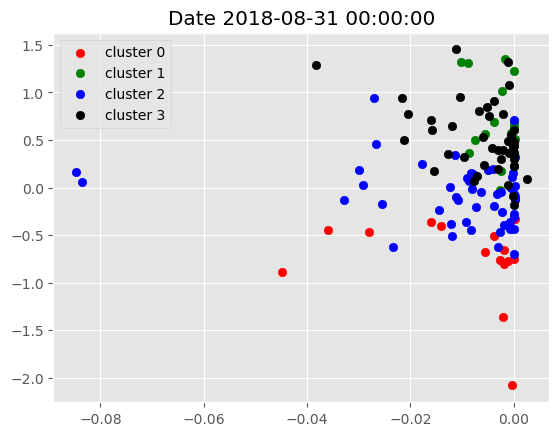

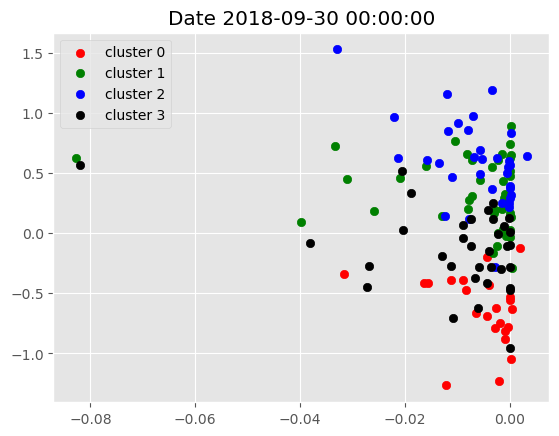

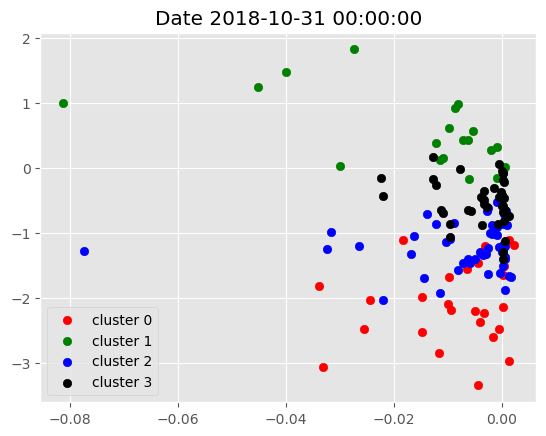

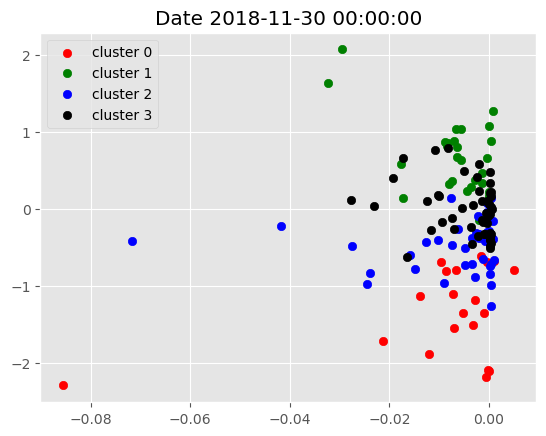

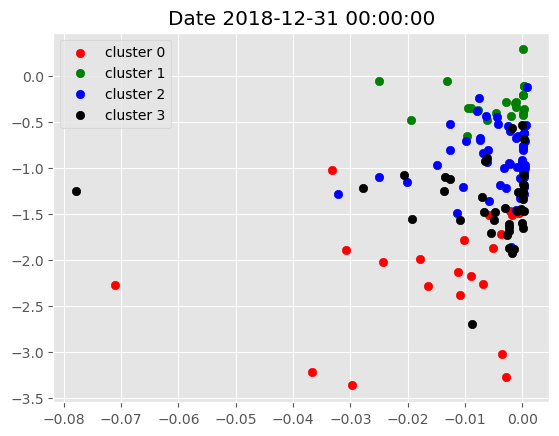

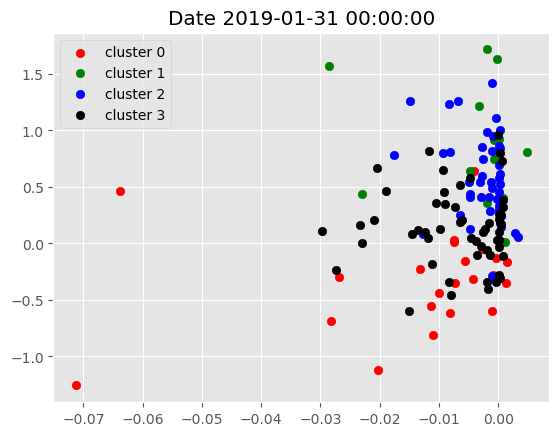

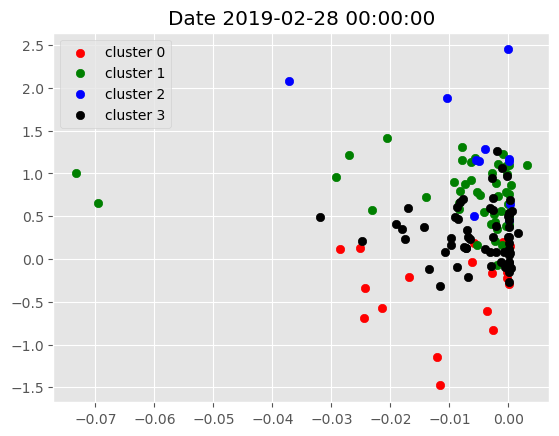

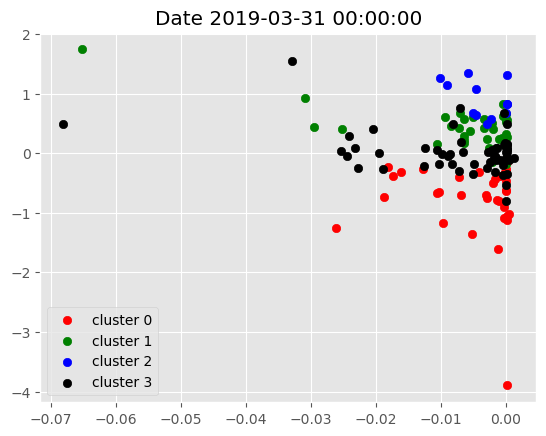

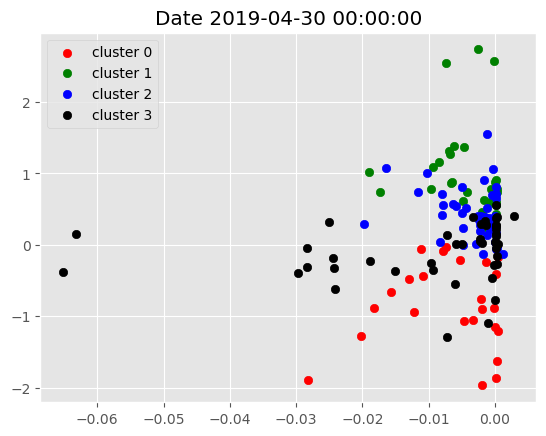

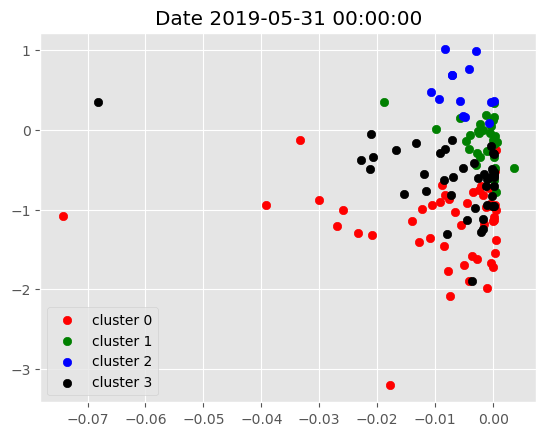

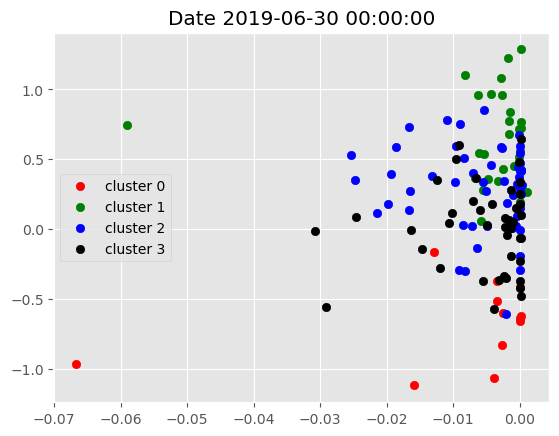

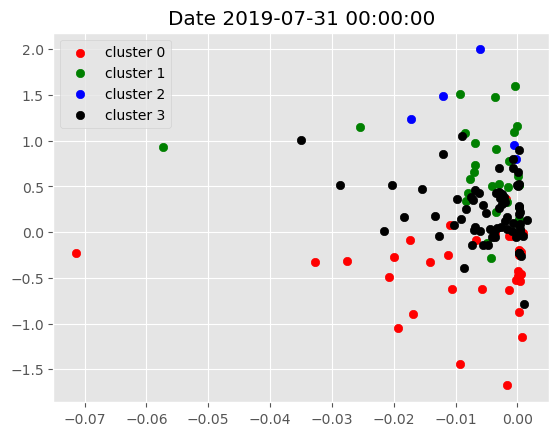

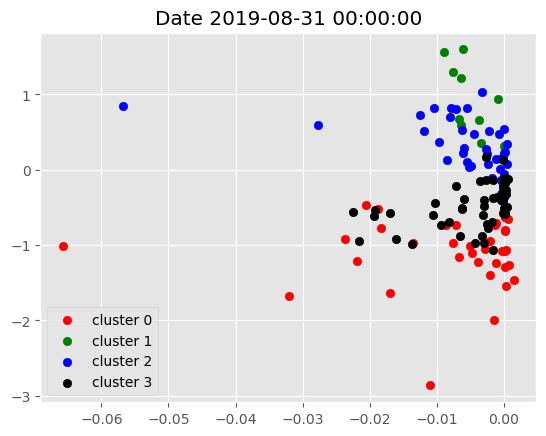

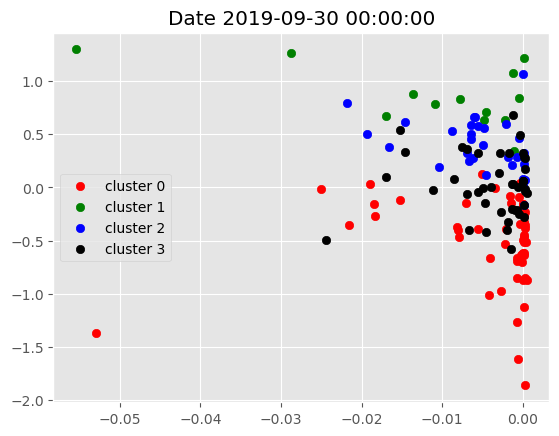

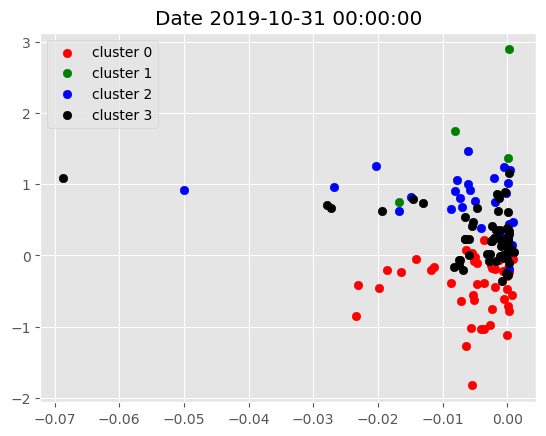

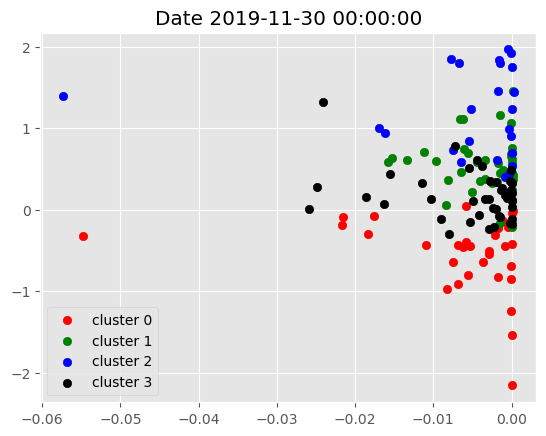

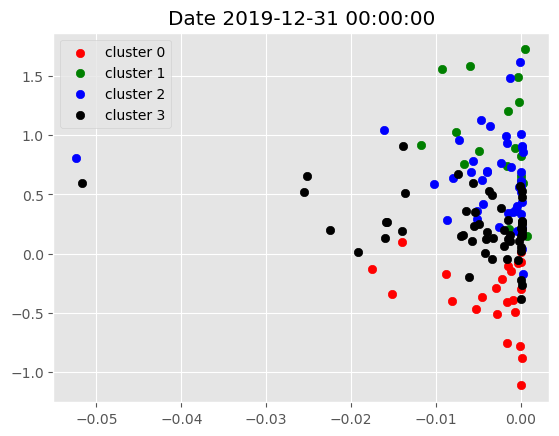

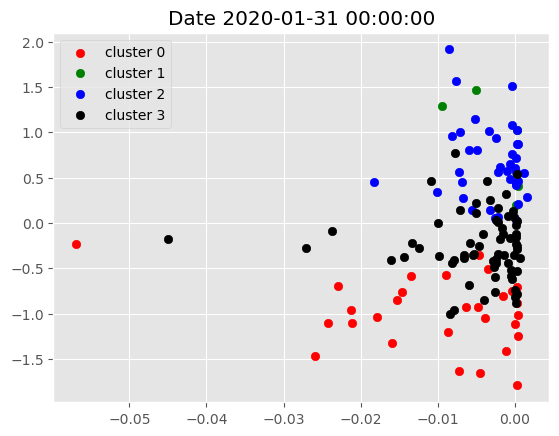

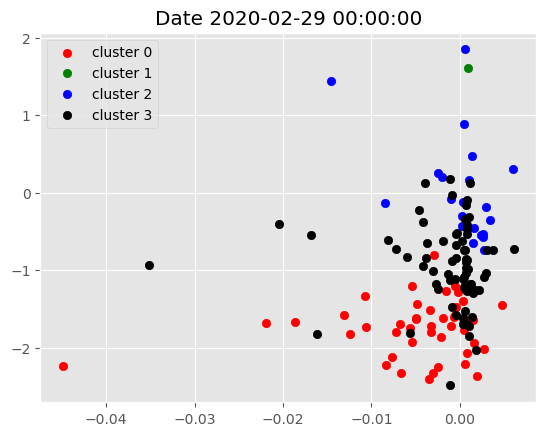

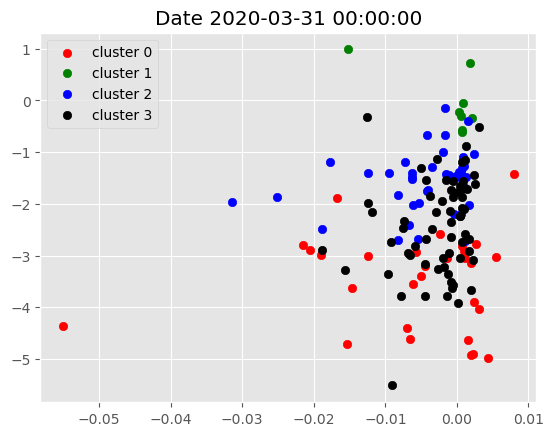

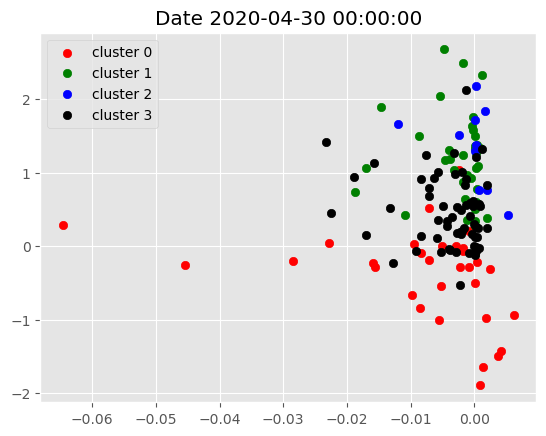

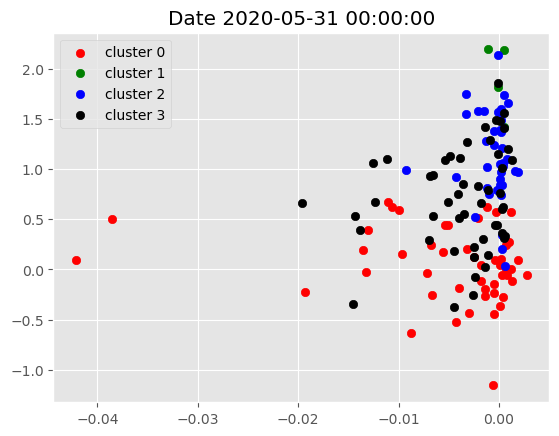

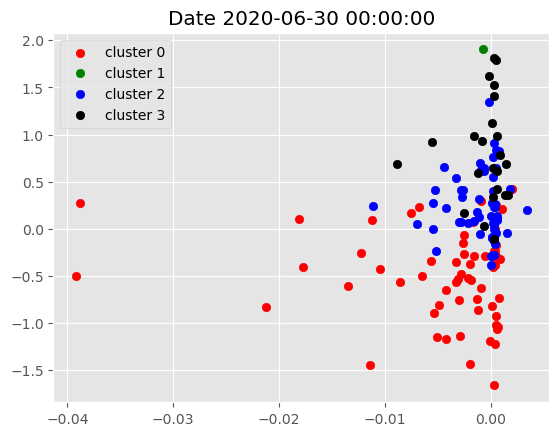

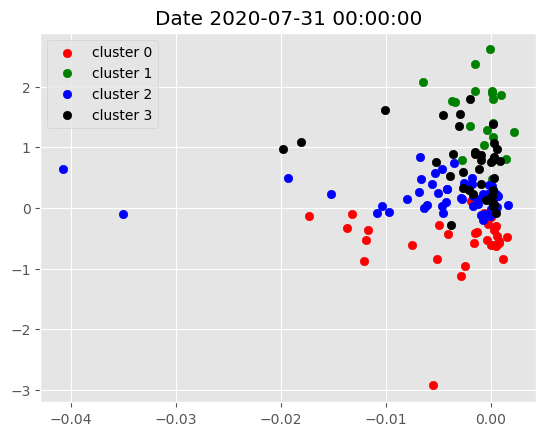

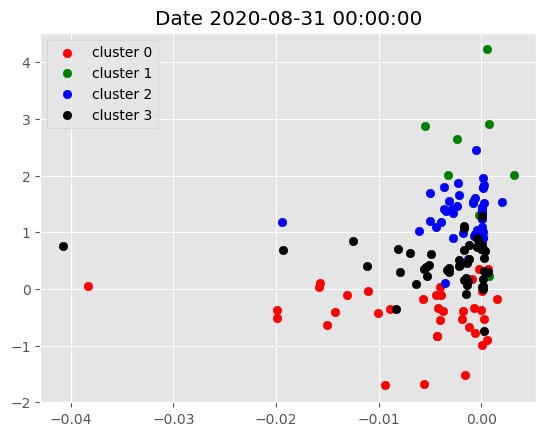

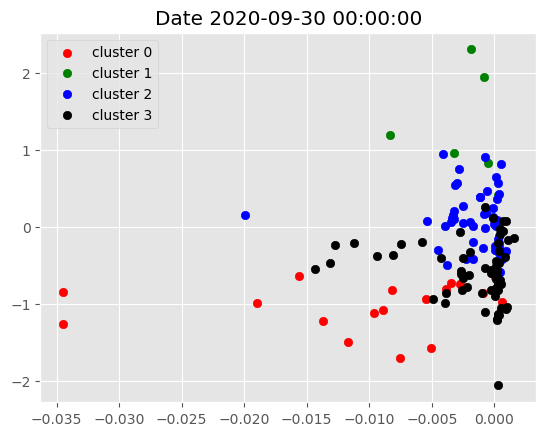

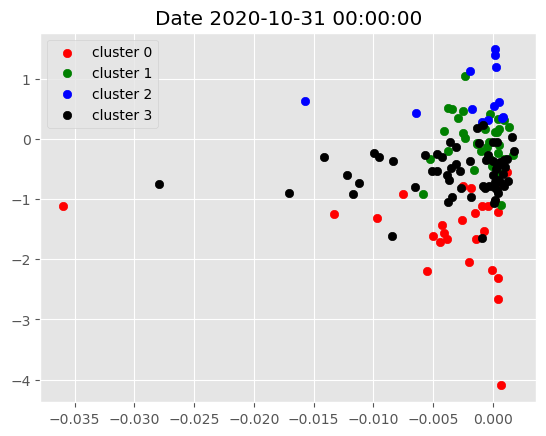

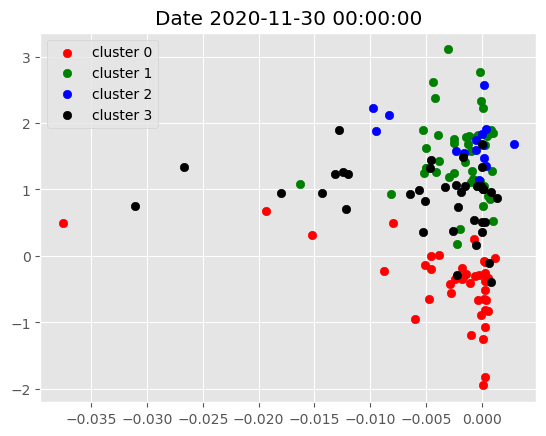

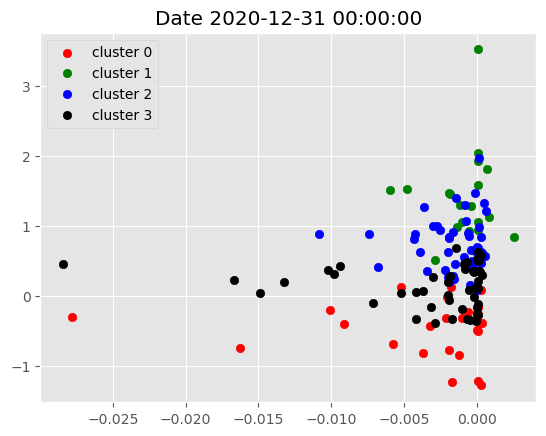

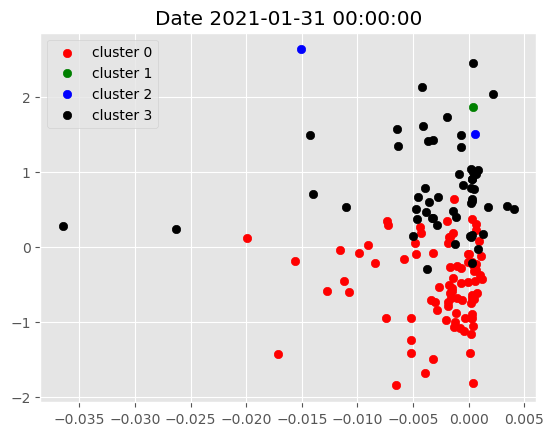

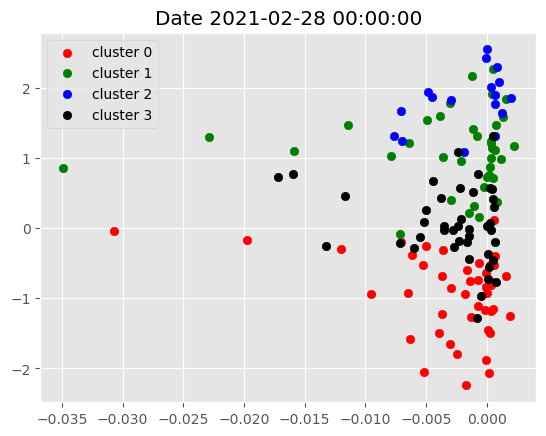

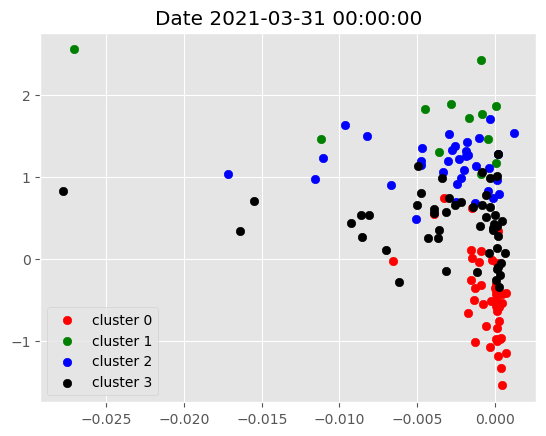

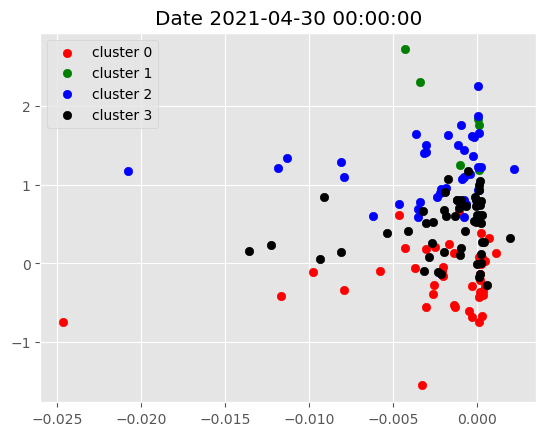

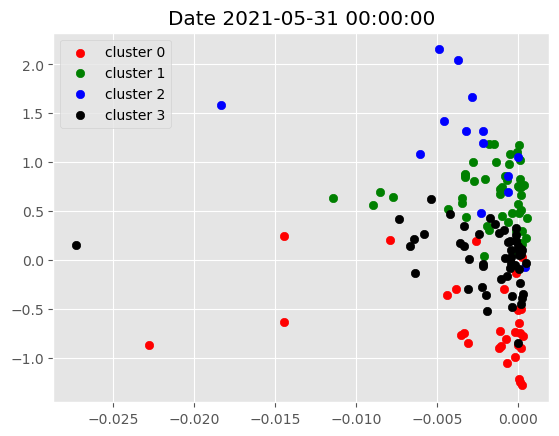

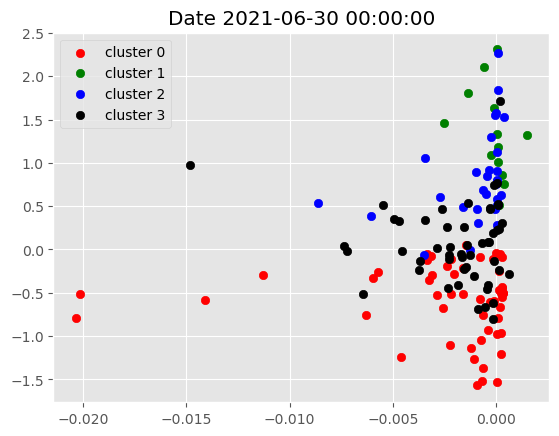

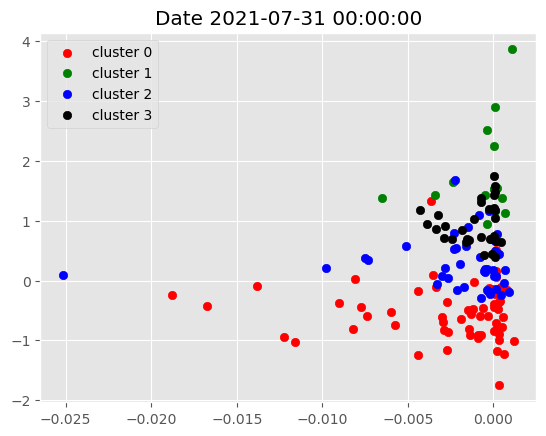

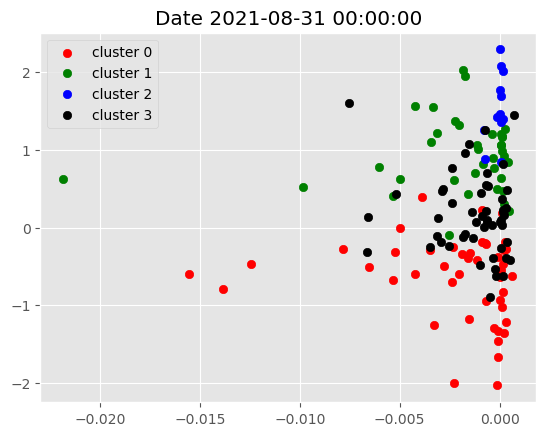

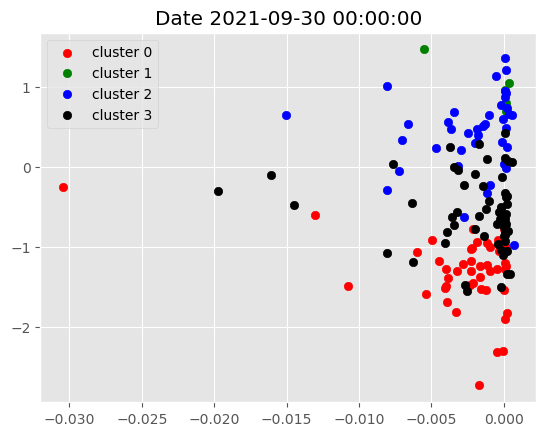

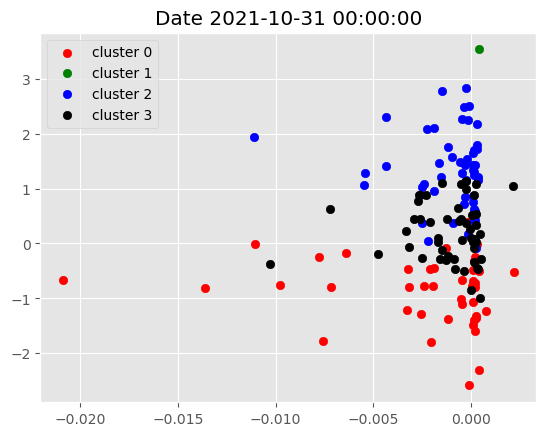

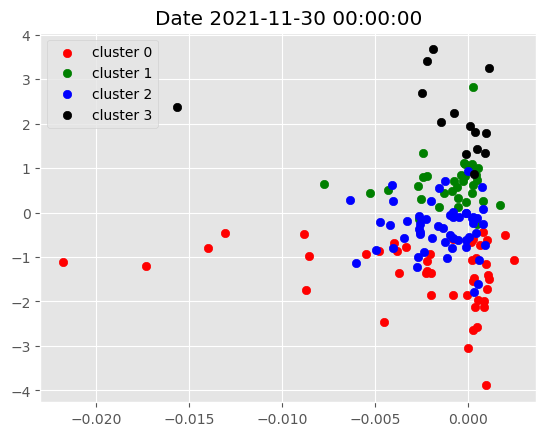

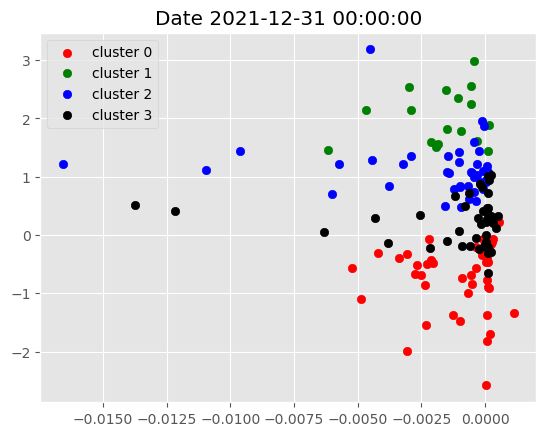

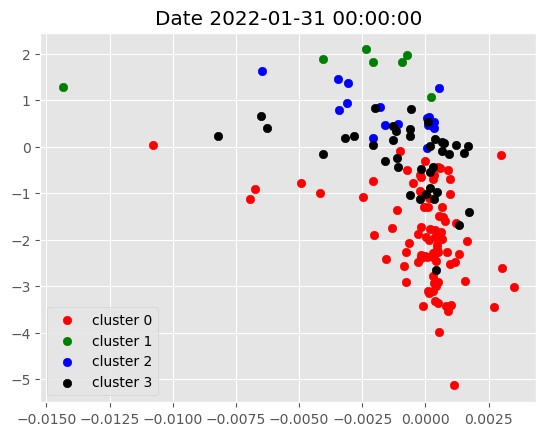

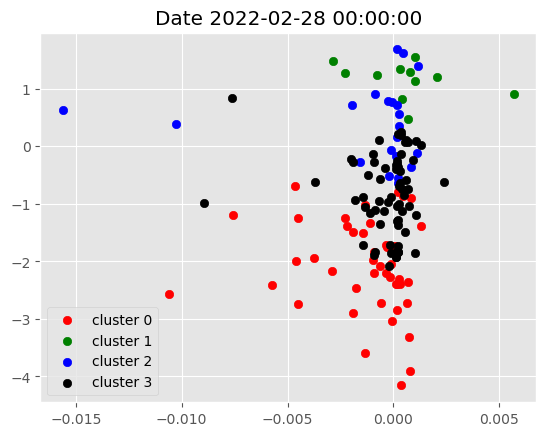

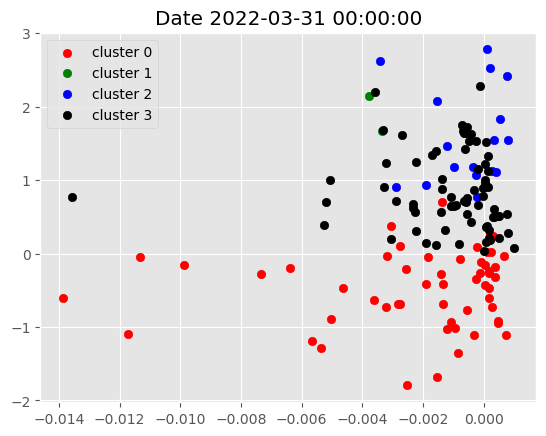

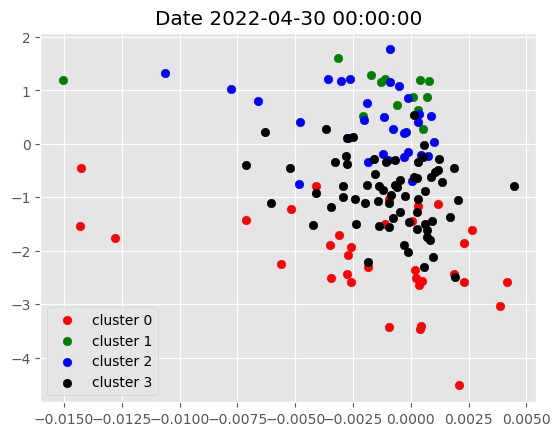

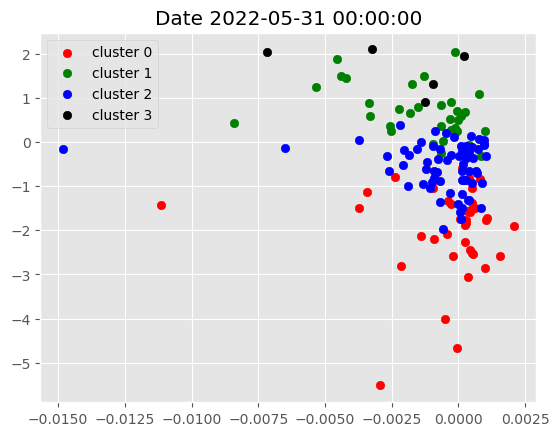

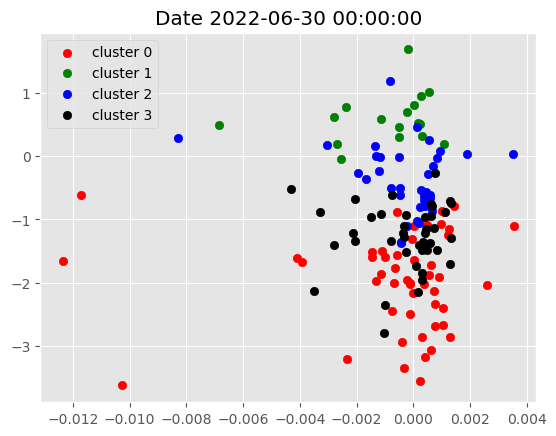

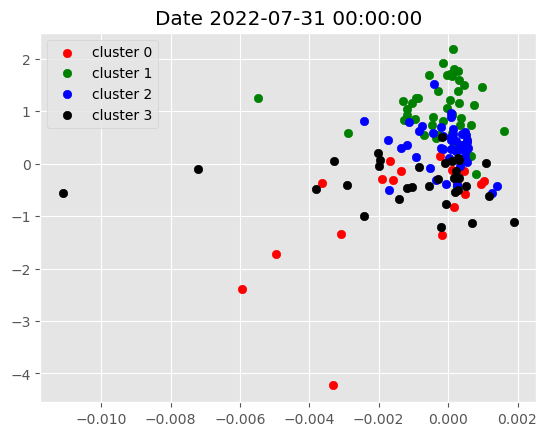

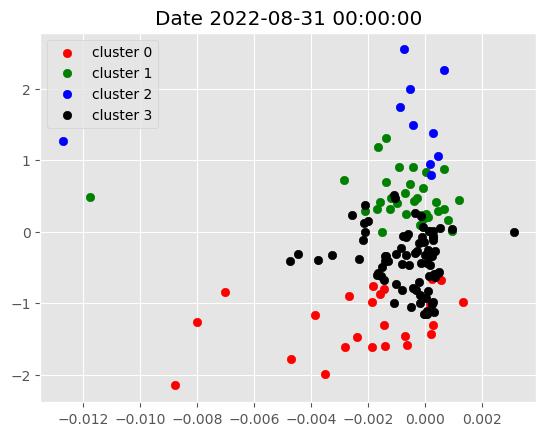

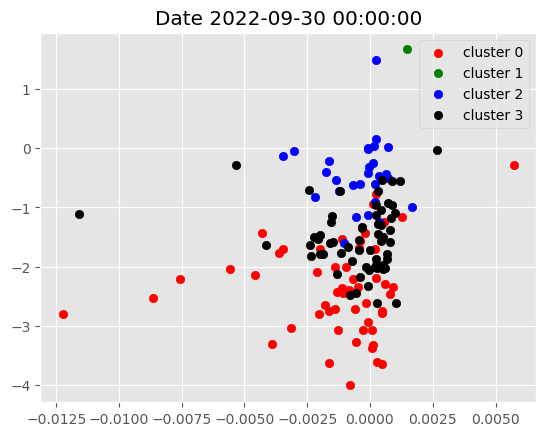

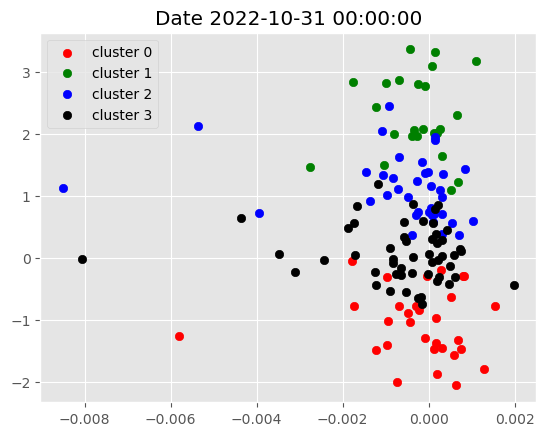

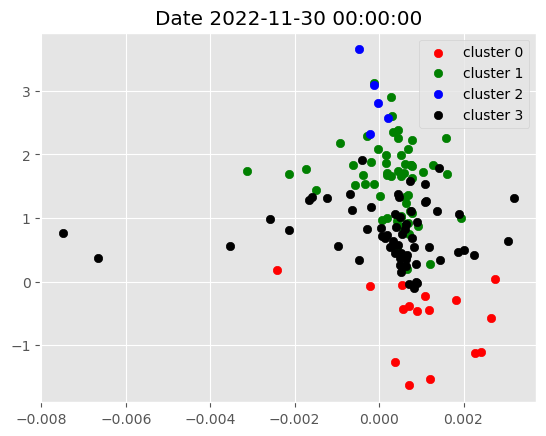

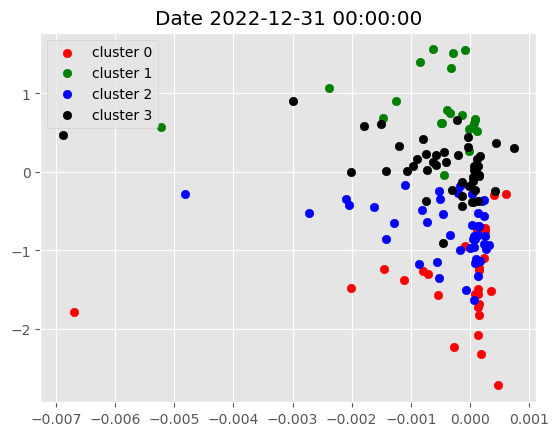

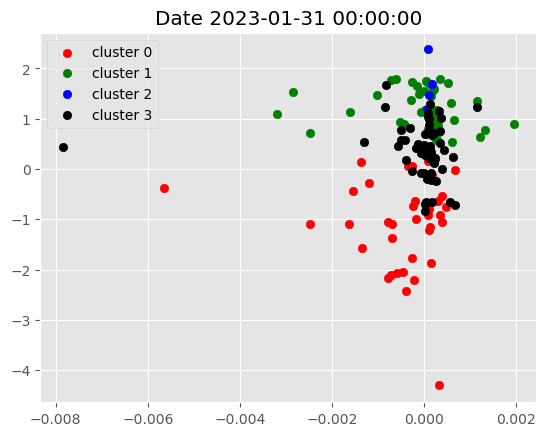

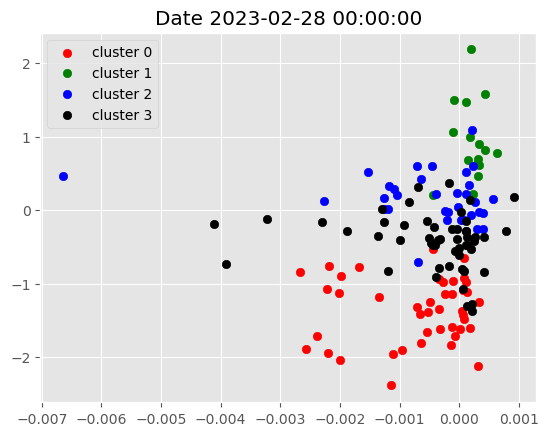

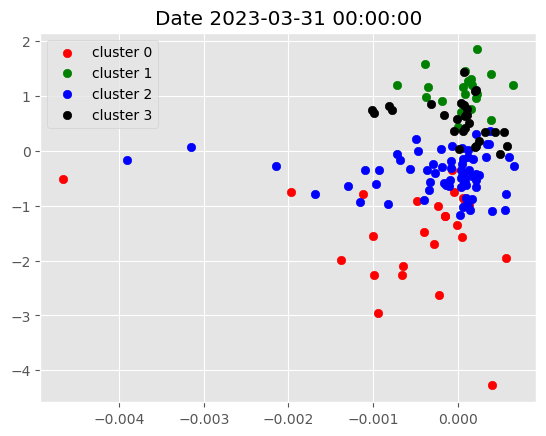

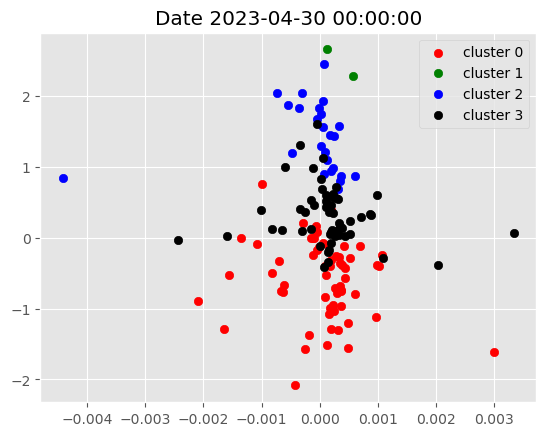

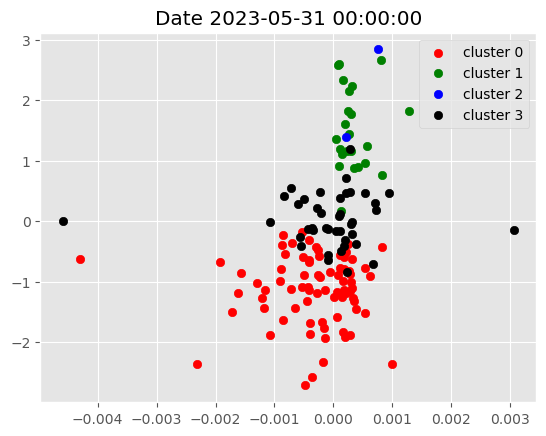

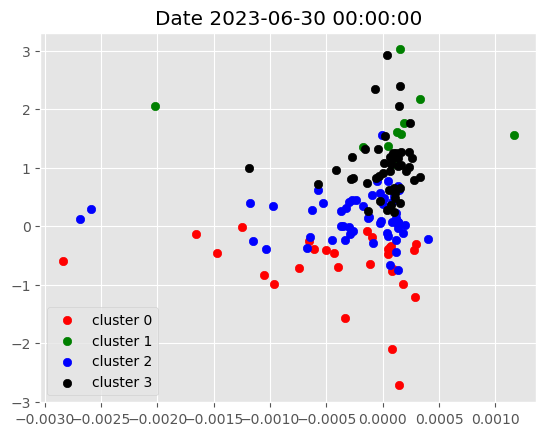

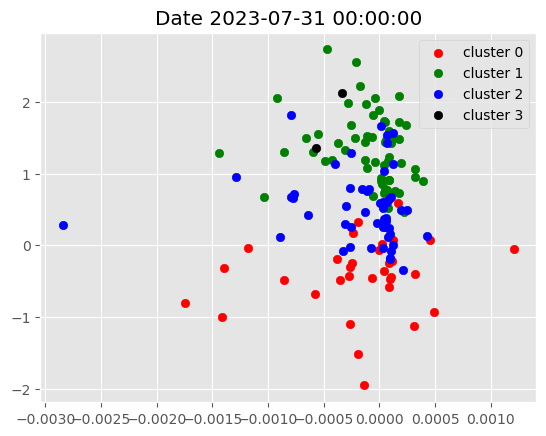

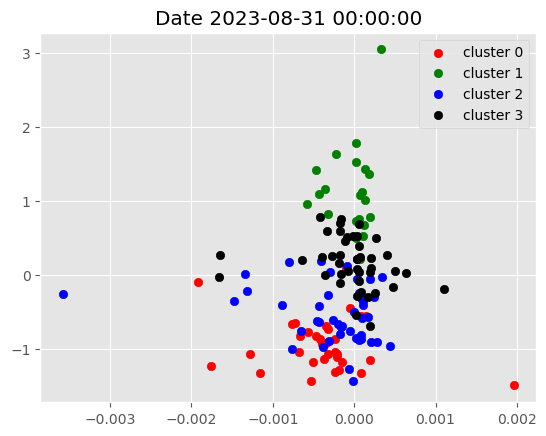

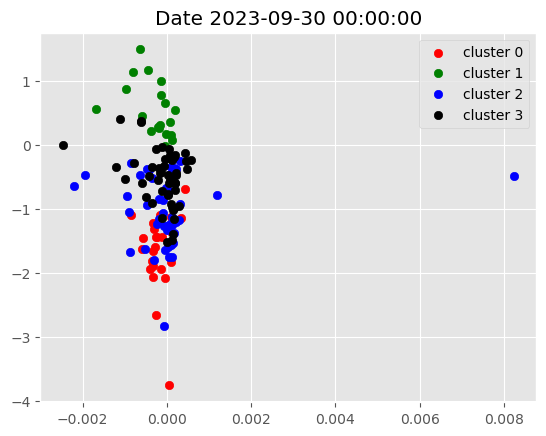

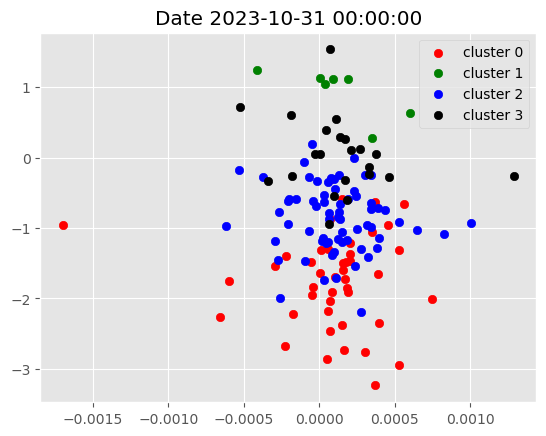

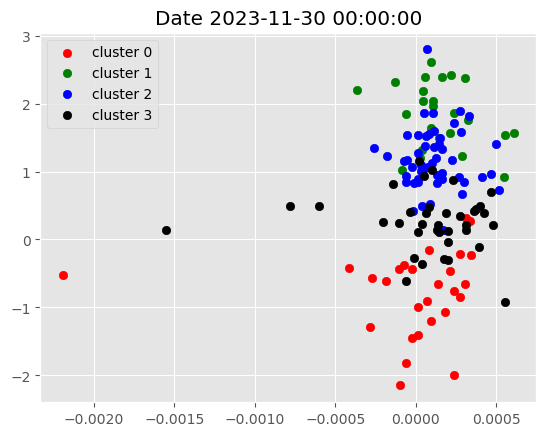

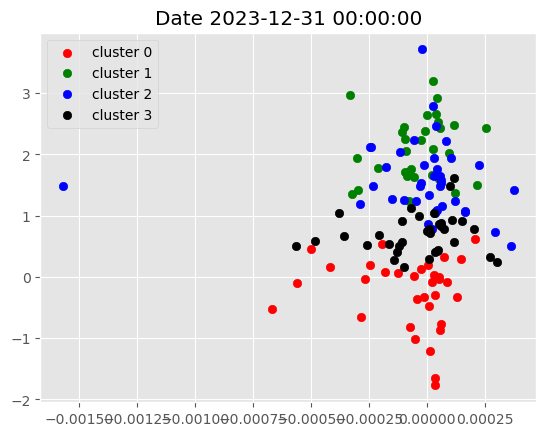

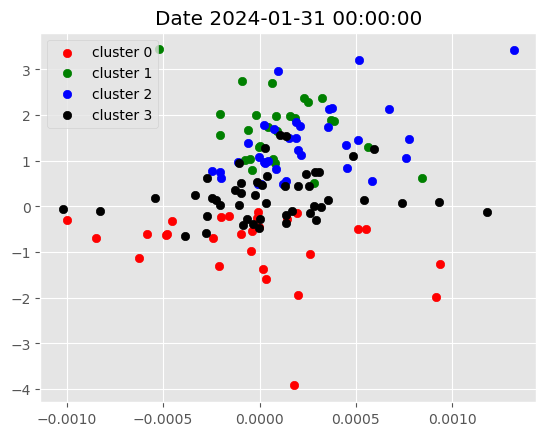

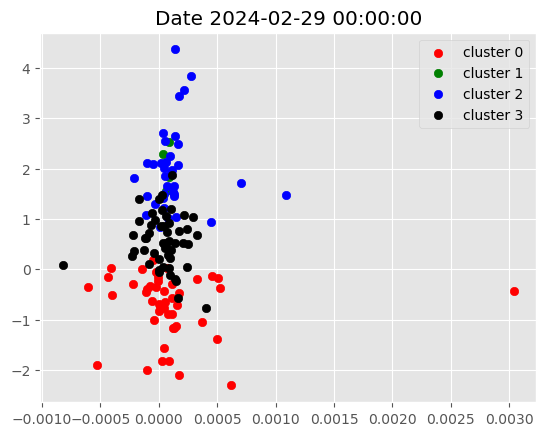

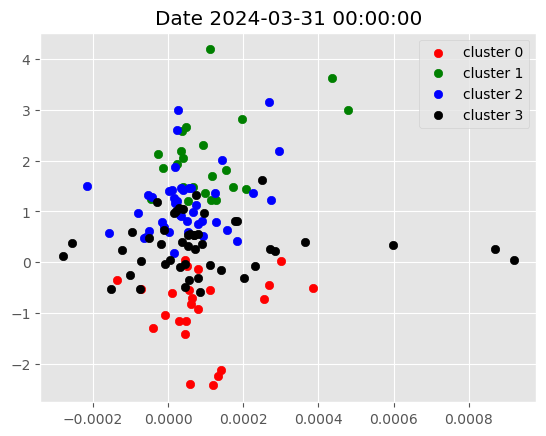

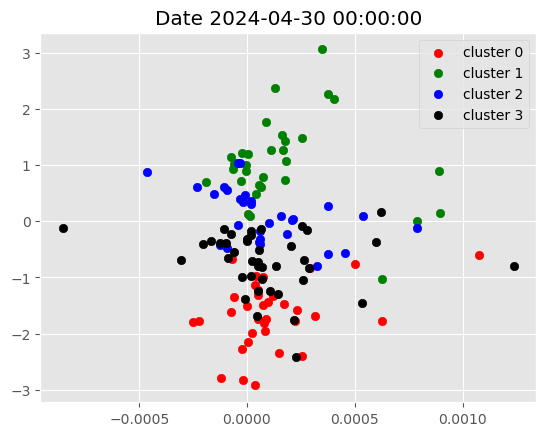

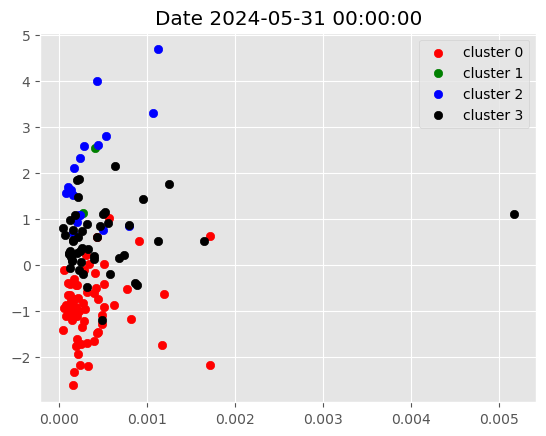

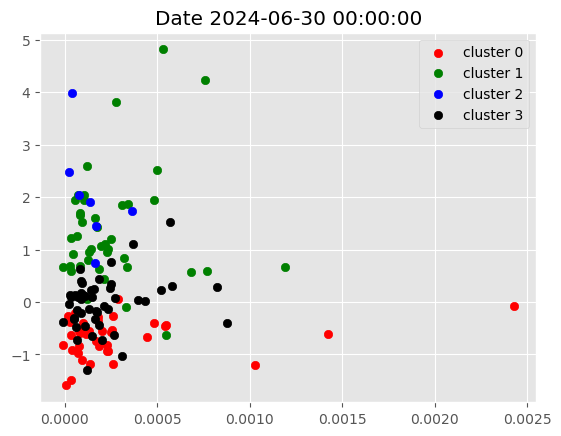

In [30]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [31]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-08-01': ['AAL',
  'AAPL',
  'ADP',
  'AIG',
  'AMAT',
  'AMZN',
  'AXP',
  'AZO',
  'BA',
  'BIIB',
  'BRK-B',
  'CAT',
  'CHTR',
  'CTSH',
  'CVX',
  'DD',
  'DE',
  'DG',
  'DHR',
  'FCX',
  'FDX',
  'GE',
  'GOOGL',
  'GS',
  'HD',
  'HUM',
  'IBM',
  'ISRG',
  'LOW',
  'LRCX',
  'MGM',
  'MO',
  'MS',
  'MSFT',
  'NEE',
  'NKE',
  'ORCL',
  'OXY',
  'SBUX',
  'SLB',
  'T',
  'TMUS',
  'TXN',
  'UNH',
  'V',
  'VRTX',
  'WBA',
  'WFC',
  'WYNN',
  'XOM'],
 '2018-09-01': ['ABT',
  'ACN',
  'ADBE',
  'AMGN',
  'AXP',
  'AZO',
  'BIIB',
  'BMY',
  'BRK-B',
  'CMCSA',
  'COP',
  'CRM',
  'CSX',
  'CVS',
  'DAL',
  'DD',
  'DG',
  'DHR',
  'ELV',
  'HD',
  'HON',
  'HUM',
  'JNJ',
  'KR',
  'LUV',
  'MA',
  'MCD',
  'MMM',
  'MRK',
  'MSFT',
  'NKE',
  'NVDA',
  'PANW',
  'PFE',
  'PG',
  'PYPL',
  'SHW',
  'TMO',
  'TMUS',
  'ULTA',
  'UNH',
  'UNP',
  'UPS',
  'USB',
  'VRTX',
  'VZ',
  'WMT'],
 '2018-10-01': ['ABBV',
  'AIG',
  'AMT',
  'AXP',
  'C',
  'CMCSA',
  'CTSH',
  'EA'

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [32]:
!pip install PyPortfolioOpt

In [33]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [34]:
stocks = data.index.get_level_values('ticker').unique().tolist()

# new_df = yf.download(tickers=stocks,
#                      start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
#                      end=data.index.get_level_values('date').unique()[-1])

# new_df

In [35]:
start_date = df_final.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12)
end_date = df_final.index.get_level_values('date').unique()[-1]

df_final = df_final.rename(index={0: "Date", 1: "Ticker"}, columns ={'adj close': 'Adj Close', 'volume': 'Volume'})

# Slice the dataframe using pd.IndexSlice
new_df = df_final.loc[pd.IndexSlice[start_date:end_date, stocks], :]
new_df = new_df.unstack()
new_df

Adj Close                                      \
ticker                           AAL        AAPL        ABBV         ABT   
date                                                                       
2016-07-05 00:00:00+00:00  27.802402   21.786543   43.482292   33.861187   
2016-07-06 00:00:00+00:00  27.245012   21.910391   44.500549   35.054573   
2016-07-07 00:00:00+00:00  28.254086   22.004427   44.542675   35.509598   
2016-07-08 00:00:00+00:00  28.869144   22.174150   45.055309   35.964634   
2016-07-11 00:00:00+00:00  29.945486   22.242960   45.188721   36.162102   
...                              ...         ...         ...         ...   
2024-06-24 00:00:00+00:00  11.160000  207.899353  171.167618  104.744308   
2024-06-25 00:00:00+00:00  11.130000  208.828293  169.195724  104.933296   
2024-06-26 00:00:00+00:00  11.120000  213.003448  169.592072  104.326515   
2024-06-27 00:00:00+00:00  11.280000  213.852478  167.451752  104.097733   
2024-06-28 00:00:00+00:00  11.330000  210.376480  169.958725  103.361641   

                                                                           \
ticker                            ACN        ADBE         ADI         ADP   
date                                                                        
2016-07-05 00:00:00+00:00   99.298965   94.730003   47.095261   78.269554   
2016-07-06 00:00:00+00:00   99.667679   95.180000   47.180317   78.361832   
2016-07-07 00:00:00+00:00   98.947754   95.139999   47.597187   78.428940   
2016-07-08 00:00:00+00:00  101.063675   96.790001   49.119949   79.242592   
2016-07-11 00:00:00+00:00  101.370956   97.139999   49.553814   79.804596   
...                               ...         ...         ...         ...   
2024-06-24 00:00:00+00:00  305.868591  524.169983  227.565002  247.946838   
2024-06-25 00:00:00+00:00  305.828796  526.880005  229.437622  247.150864   
2024-06-26 00:00:00+00:00  303.289917  528.659973  226.947418  236.823074   
2024-06-27 00:00:00+00:00  301.866150  546.760010  225.791962  236.106689   
2024-06-28 00:00:00+00:00  302.085205  555.539978  227.365768  237.489700   

                                                  ...      Volume  \
ticker                           ADSK        AIG  ...          VZ   
date                                              ...               
2016-07-05 00:00:00+00:00   52.799999  41.655479  ...  20703200.0   
2016-07-06 00:00:00+00:00   52.959999  41.696156  ...  15761500.0   
2016-07-07 00:00:00+00:00   53.529999  42.151672  ...  13574100.0   
2016-07-08 00:00:00+00:00   55.139999  43.119640  ...  15946200.0   
2016-07-11 00:00:00+00:00   55.490002  43.347401  ...  12434700.0   
...                               ...        ...  ...         ...   
2024-06-24 00:00:00+00:00  239.169998  76.010002  ...  20773800.0   
2024-06-25 00:00:00+00:00  242.529999  74.510002  ...  18933000.0   
2024-06-26 00:00:00+00:00  243.279999  74.489998  ...  19709900.0   
2024-06-27 00:00:00+00:00  243.679993  74.970001  ...  15560800.0   
2024-06-28 00:00:00+00:00  247.449997  74.239998  ...  27639200.0   

                                                                           \
ticker                             WBA        WDC         WFC         WMT   
date                                                                        
2016-07-05 00:00:00+00:00    7629300.0  5728200.0  22213000.0  32245800.0   
2016-07-06 00:00:00+00:00   10537400.0  4268600.0  19024100.0  33188100.0   
2016-07-07 00:00:00+00:00    5560000.0  7831800.0  17946200.0  23378400.0   
2016-07-08 00:00:00+00:00    5973500.0  7267200.0  19775700.0  27382800.0   
2016-07-11 00:00:00+00:00    3607700.0  5546200.0  16008700.0  27120300.0   
...                                ...        ...         ...         ...   
2024-06-24 00:00:00+00:00   13632500.0  5122600.0  16198300.0  12470400.0   
2024-06-25 00:00:00+00:00   10336600.0  3764400.0  27490700.0  20904000.0   
2024-06-26 00:00:00+00:00   12933400.0  3663400.0  30425700.0  141775

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [36]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
returns_dataframe

ticker,AAL,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AIG,...,VZ,WBA,WDC,WFC,WMT,WYNN,XOM,MRNA,UBER,CRWD
date,,,,,,,,,,,,,,,,,,,,,
2016-07-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-06 00:00:00+00:00,-0.020252,0.005669,0.023148,0.034637,0.003706,0.004739,0.001804,0.001178,0.003026,0.000976,...,0.005257,-0.023870,0.016412,0.009477,0.009254,0.009272,0.011437,NaN,NaN,NaN
2016-07-07 00:00:00+00:00,0.036368,0.004283,0.000946,0.012897,-0.007249,-0.000420,0.008797,0.000856,0.010705,0.010865,...,-0.015765,-0.012959,0.047260,0.003210,-0.003936,-0.010844,-0.012082,NaN,NaN,NaN
2016-07-08 00:00:00+00:00,0.021535,0.007684,0.011443,0.012733,0.021159,0.017194,0.031492,0.010321,0.029633,0.022704,...,0.009346,0.016020,0.034845,0.020933,0.004207,0.008841,0.006220,NaN,NaN,NaN
2016-07-11 00:00:00+00:00,0.036605,0.003098,0.002957,0.005476,0.003036,0.003610,0.008794,0.007067,0.006327,0.005268,...,0.000537,0.002564,0.002631,0.006050,0.002975,0.047330,0.003735,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24 00:00:00+00:00,-0.003578,0.003128,0.013698,-0.003981,-0.005745,-0.017531,-0.011273,0.004948,-0.013043,0.014845,...,0.022848,-0.003764,-0.004895,0.015541,0.014473,-0.008716,0.029271,0.026629,0.004689,-0.007119
2024-06-25 00:00:00+00:00,-0.002692,0.004458,-0.011587,0.001803,-0.000130,0.005157,0.008195,-0.003215,0.013951,-0.019932,...,-0.002188,-0.013287,0.019178,-0.031153,-0.021715,-0.009019,0.002802,0.004370,0.011838,0.023095
2024-06-26 00:00:00+00:00,-0.000899,0.019796,0.002340,-0.005799,-0.008336,0.003373,-0.010913,-0.042686,0.003088,-0.000269,...,-0.001462,-0.002551,-0.018250,-0.003327,0.012822,-0.001927,0.000350,-0.116648,-0.007453,-0.016660


In [37]:
fixed_dates.keys()

dict_keys(['2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-

In [38]:
for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    cols = fixed_dates[start_date]
    optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
#     optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
     
    print(start_date)
    print(end_date)
    print(cols)
    print(optimization_start_date)
    print(optimization_end_date)

2018-08-01
2018-08-31
['AAL', 'AAPL', 'ADP', 'AIG', 'AMAT', 'AMZN', 'AXP', 'AZO', 'BA', 'BIIB', 'BRK-B', 'CAT', 'CHTR', 'CTSH', 'CVX', 'DD', 'DE', 'DG', 'DHR', 'FCX', 'FDX', 'GE', 'GOOGL', 'GS', 'HD', 'HUM', 'IBM', 'ISRG', 'LOW', 'LRCX', 'MGM', 'MO', 'MS', 'MSFT', 'NEE', 'NKE', 'ORCL', 'OXY', 'SBUX', 'SLB', 'T', 'TMUS', 'TXN', 'UNH', 'V', 'VRTX', 'WBA', 'WFC', 'WYNN', 'XOM']
2017-08-01
2018-07-31
2018-09-01
2018-09-30
['ABT', 'ACN', 'ADBE', 'AMGN', 'AXP', 'AZO', 'BIIB', 'BMY', 'BRK-B', 'CMCSA', 'COP', 'CRM', 'CSX', 'CVS', 'DAL', 'DD', 'DG', 'DHR', 'ELV', 'HD', 'HON', 'HUM', 'JNJ', 'KR', 'LUV', 'MA', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'NVDA', 'PANW', 'PFE', 'PG', 'PYPL', 'SHW', 'TMO', 'TMUS', 'ULTA', 'UNH', 'UNP', 'UPS', 'USB', 'VRTX', 'VZ', 'WMT']
2017-09-01
2018-08-31
2018-10-01
2018-10-31
['ABBV', 'AIG', 'AMT', 'AXP', 'C', 'CMCSA', 'CTSH', 'EA', 'EXPE', 'FCX', 'FDX', 'GOOG', 'GOOGL', 'HAL', 'INTC', 'JPM', 'KR', 'MCK', 'MDLZ', 'MGM', 'MMM', 'MO', 'NEE', 'PANW', 'PEP', 'PG', 'PYPL', '

In [39]:


portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),4))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['date', 'ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-08-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2018-08-01 00:00:00+00:00,-0.003319
2018-08-02 00:00:00+00:00,0.002960
2018-08-03 00:00:00+00:00,0.002539
2018-08-06 00:00:00+00:00,0.002822
2018-08-07 00:00:00+00:00,0.002819
...,...
2024-06-24 00:00:00+00:00,0.004042
2024-06-25 00:00:00+00:00,0.003061
2024-06-26 00:00:00+00:00,-0.002369


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [45]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold_x,SPY Buy&Hold_y,SPY Buy&Hold
2018-08-01,-0.003319,-0.001672,-0.001672,-0.001672
2018-08-02,0.002960,0.005433,0.005433,0.005433
2018-08-03,0.002539,0.004275,0.004275,0.004275
2018-08-06,0.002822,0.003661,0.003661,0.003661
2018-08-07,0.002819,0.003297,0.003297,0.003297
...,...,...,...,...
2024-06-24,0.004042,-0.003256,-0.003256,-0.003256
2024-06-25,0.003061,0.003843,0.003843,0.003843
2024-06-26,-0.002369,0.001247,0.001247,0.001247
2024-06-27,-0.009044,0.001575,0.001575,0.001575


In [46]:
portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

MergeError: Passing 'suffixes' which cause duplicate columns {'SPY Buy&Hold_x'} is not allowed.

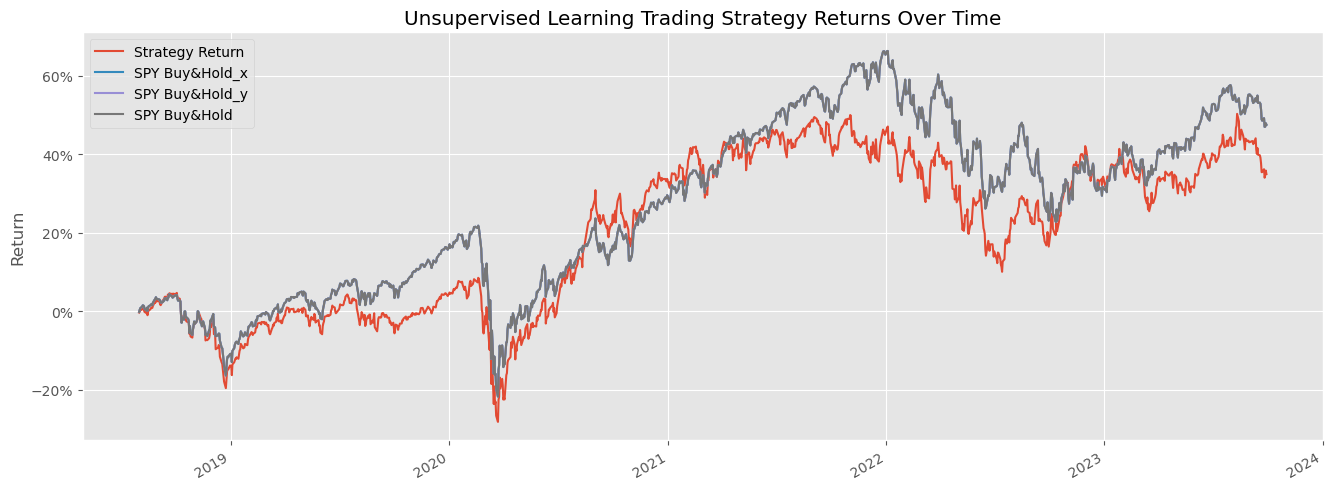

In [47]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

In [51]:
os.makedirs('results', exist_ok=True)

In [54]:

stocks_df = pd.DataFrame(stocks, columns=['stock'])
results_dir = os.path.join('..', 'results')

os.makedirs(results_dir, exist_ok=True)

file_path = os.path.join(results_dir, 'ML_result.csv')

stocks_df.to_csv(file_path, index=False)

print(f"saved to {file_path}")


saved to ../results/ML_result.csv
